# This is the step-wise flow of the program
1. Getting all required libraries
2. Importing and preprocessing boston housing dataset
3. Quantile Regression - Model 1
4. Evaulating QR - PICP, MPIW
5. Evaluating QR - No. of estimators
5. Auxiliary Interval Predictor - Model 2
6. Evaluating AIP - PICP, MPIW
7. Uncertainty Characteristics Curve - Comparsion

In [1]:
#Getting all required libraries 
import matplotlib.pyplot as plt
from uq360.algorithms.quantile_regression import QuantileRegression
from uq360.metrics import picp, mpiw, compute_regression_metrics, plot_uncertainty_distribution, plot_uncertainty_by_feature, plot_picp_by_feature
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from uq360.algorithms.auxiliary_interval_predictor import AuxiliaryIntervalPredictor
import torch
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
from uq360.metrics.uncertainty_characteristics_curve import UncertaintyCharacteristicsCurve as ucc

In [2]:
#Using Boston-housing dataset
house_prices_dataset = datasets.load_boston()
house_prices_df = pd.DataFrame(house_prices_dataset['data'])
house_prices_df.columns = house_prices_dataset['feature_names']

all_features = ['RM','CRIM','PTRATIO', 'DIS']
X = house_prices_df[all_features].values
y = house_prices_dataset['target']

In [3]:
#splitting train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_train.shape
y_test.shape

(152,)

Text(0.5, 1.0, 'Training data')

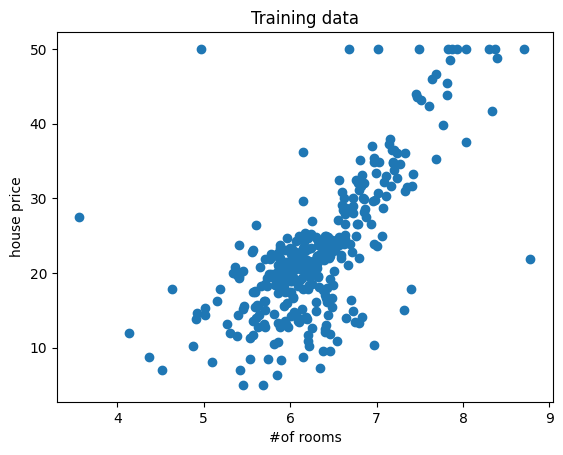

In [4]:
# Visualising data spread with no. of rooms
plt.scatter(X_train[:,0], y_train)
plt.xlabel('#of rooms')
plt.ylabel('house price')
plt.title('Training data')

In [5]:
#Pre-processing data
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1))
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

In [6]:
# Quantile Regression model
config_qr = {
    "alpha":0.95,
    "n_estimators":20,
    "max_depth":3,
    "learning_rate":0.1,
    "min_samples_leaf":20,
    "min_samples_split":20
}

uq_model_qr = QuantileRegression(model_type='gbr', config=config_qr)

In [7]:
uq_model_qr = uq_model_qr.fit(X_train, y_train.squeeze())

In [8]:
y_mean_qr, y_lower_qr, y_upper_qr = uq_model_qr.predict(X_test)

In [9]:
# inverse transforming predicted values
y_mean_qr, y_lower_qr, y_upper_qr = scaler_y.inverse_transform(y_mean_qr.reshape(-1,1)), scaler_y.inverse_transform(y_lower_qr.reshape(-1,1)), scaler_y.inverse_transform(y_upper_qr.reshape(-1,1))

In [10]:
# preparing results in the format to plot
pred_dict_qr = {'rooms': scaler_X.inverse_transform(X_test)[:,0].flatten(),'y_test': y_test.flatten(),'y_mean': y_mean_qr.flatten(),'y_upper': y_upper_qr.flatten(),'y_lower': y_lower_qr.flatten()} #flatten takes n time

pred_df_qr = pd.DataFrame(data=pred_dict_qr)

pred_df_qr_sorted = pred_df_qr.sort_values(by='rooms')

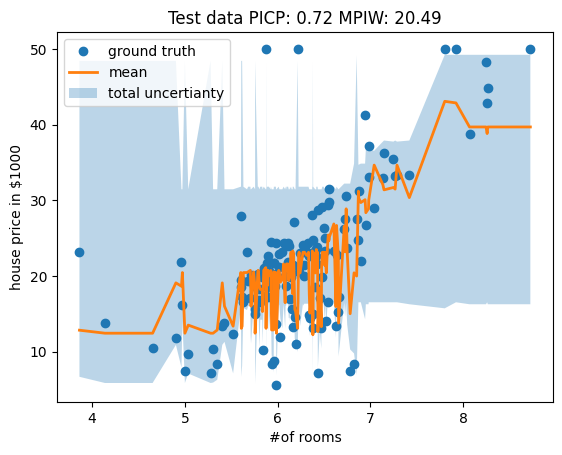

In [11]:
# Plotting predictions with the PICP and MPIW metrics
plt.plot(pred_df_qr_sorted['rooms'], pred_df_qr_sorted['y_test'], 'o', label='ground truth')
plt.plot(pred_df_qr_sorted['rooms'], pred_df_qr_sorted['y_mean'], '-', lw=2, label='mean')
plt.fill_between(pred_df_qr_sorted['rooms'],
                         pred_df_qr_sorted['y_upper'],
                         pred_df_qr_sorted['y_lower'],
                         alpha=0.3, label='total uncertianty')
plt.legend()
plt.xlabel('#of rooms')
plt.ylabel('house price in $1000')
plt.title('Test data PICP: {:.2f} MPIW: {:.2f}'.format(
    picp(y_test, y_lower_qr, y_upper_qr), #direct function PICP
    mpiw(y_lower_qr, y_upper_qr))) #direct function MPIW
plt.show()

In [12]:
#checking scores of metrics
compute_regression_metrics(y_test.reshape(-1,1), y_mean_qr, y_lower_qr, y_upper_qr)

{'rmse': 5.95275338972838,
 'nll': 2.9116479017158396,
 'auucc_gain': -0.23644846101969086,
 'picp': 0.881578947368421,
 'mpiw': 20.492301889695252,
 'r2': 0.5744303196525262}

In [13]:
#Evaluating model on parameters as number of estimators change
num_estimators_arr = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
observed_alphas = np.zeros(len(num_estimators_arr))
observed_widths = np.zeros(len(num_estimators_arr))
rmses = np.zeros(len(num_estimators_arr))

for idx, num_estimators in enumerate(num_estimators_arr):
    
    config_qr["n_estimators"] = num_estimators
    uq_model = QuantileRegression(model_type='gbr', config=config_qr)
    uq_model = uq_model.fit(X_train, y_train.squeeze())
    y_mean, y_lower, y_upper = uq_model.predict(X_test)
    y_mean, y_lower, y_upper = scaler_y.inverse_transform(y_mean.reshape(-1,1)), scaler_y.inverse_transform(y_lower.reshape(-1,1)), scaler_y.inverse_transform(y_upper.reshape(-1,1))
    observed_alphas[idx] = picp(y_test, y_lower, y_upper)
    observed_widths[idx] = mpiw(y_lower, y_upper)
    rmses[idx] = np.sqrt(mean_squared_error(y_test, y_mean))

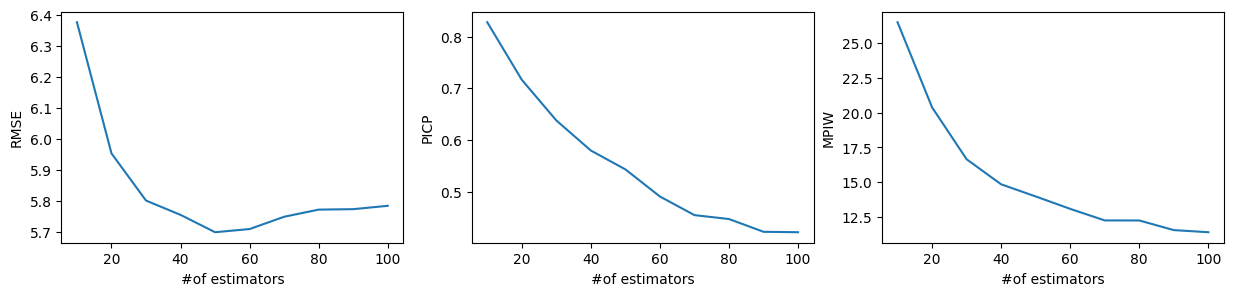

In [14]:
plt.figure(figsize=(15,3))
plt.subplot(1, 3, 1)
plt.plot(num_estimators_arr, rmses)
plt.ylabel('RMSE')
plt.xlabel('#of estimators')
plt.subplot(1, 3, 2)
plt.plot(num_estimators_arr, observed_alphas)
plt.xlabel('#of estimators')
plt.ylabel('PICP')
plt.subplot(1, 3, 3)
plt.plot(num_estimators_arr, observed_widths)
plt.xlabel('#of estimators')
plt.ylabel('MPIW')
plt.show()

In [15]:
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
config_aip = {"num_features": X_train.shape[1], "num_outputs": y_train.shape[1], "num_hidden": 50, "batch_size": 32,
                  "lr": 0.01, "num_main_iters": 50, "num_aux_iters": 5, "num_outer_iters": 5,
                  "lambda_noise": 0.001, "lambda_sharpness": 0.01, "lambda_match": 1.0, "calibration_alpha": 0.90}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
uq_model_aip = AuxiliaryIntervalPredictor(model_type='mlp', config=config_aip, device=device) # mlp - multi-layer perceptron

In [16]:
uq_model_aip = uq_model_aip.fit(X_train, y_train)

Iter: 0,  Epoch: 0, main_model_loss = 0.35444289321700734
Iter: 0,  Epoch: 1, main_model_loss = 0.22940429920951527
Iter: 0,  Epoch: 2, main_model_loss = 0.19649613214035827
Iter: 0,  Epoch: 3, main_model_loss = 0.16679945029318333
Iter: 0,  Epoch: 4, main_model_loss = 0.152400774260362
Iter: 0,  Epoch: 5, main_model_loss = 0.14197713881731033
Iter: 0,  Epoch: 6, main_model_loss = 0.1355592260758082
Iter: 0,  Epoch: 7, main_model_loss = 0.1365214915325244
Iter: 0,  Epoch: 8, main_model_loss = 0.1337261398633321
Iter: 0,  Epoch: 9, main_model_loss = 0.13246801619728404
Iter: 0,  Epoch: 10, main_model_loss = 0.12922446926434833
Iter: 0,  Epoch: 11, main_model_loss = 0.1281825325762232
Iter: 0,  Epoch: 12, main_model_loss = 0.12766601890325546
Iter: 0,  Epoch: 13, main_model_loss = 0.12610244378447533
Iter: 0,  Epoch: 14, main_model_loss = 0.12684108503162858
Iter: 0,  Epoch: 15, main_model_loss = 0.13935491939385733
Iter: 0,  Epoch: 16, main_model_loss = 0.1705995701874296
Iter: 0,  Epoc

Iter: 2,  Epoch: 34, main_model_loss = 0.5011521068712075
Iter: 2,  Epoch: 35, main_model_loss = 0.49006302530566864
Iter: 2,  Epoch: 36, main_model_loss = 0.48256375143925345
Iter: 2,  Epoch: 37, main_model_loss = 0.48209648082653683
Iter: 2,  Epoch: 38, main_model_loss = 0.47260953237613046
Iter: 2,  Epoch: 39, main_model_loss = 0.47498734295368195
Iter: 2,  Epoch: 40, main_model_loss = 0.4811617235342662
Iter: 2,  Epoch: 41, main_model_loss = 0.4719987586140632
Iter: 2,  Epoch: 42, main_model_loss = 0.49526714781920117
Iter: 2,  Epoch: 43, main_model_loss = 0.5083572256068389
Iter: 2,  Epoch: 44, main_model_loss = 0.4843610264360905
Iter: 2,  Epoch: 45, main_model_loss = 0.4941440125306448
Iter: 2,  Epoch: 46, main_model_loss = 0.5253635868430138
Iter: 2,  Epoch: 47, main_model_loss = 0.5004551820456982
Iter: 2,  Epoch: 48, main_model_loss = 0.48392584547400475
Iter: 2,  Epoch: 49, main_model_loss = 0.4929746786753336
Iter: 2,  Epoch: 0, aux_model_loss = 0.17597098369151354
Iter: 2,

In [17]:
y_mean_aip, y_lower_aip, y_upper_aip = uq_model_aip.predict(X_test)
y_mean_aip, y_lower_aip, y_upper_aip = scaler_y.inverse_transform(y_mean_aip), scaler_y.inverse_transform(y_lower_aip), scaler_y.inverse_transform(y_upper_aip)
X_test = scaler_X.inverse_transform(X_test)

In [18]:
pred_dict_aip = {'rooms': X_test[:,0],
             'y_test': y_test[:,0],
             'y_mean': y_mean_aip[:,0],
             'y_upper': y_upper_aip[:,0],
             'y_lower': y_lower_aip[:,0]
            }

pred_df_aip = pd.DataFrame(data=pred_dict_aip)

pred_df_aip_sorted = pred_df_aip.sort_values(by='rooms')

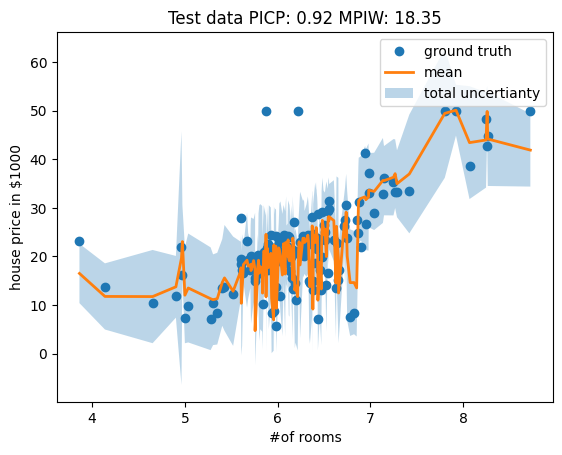

In [19]:
plt.plot(pred_df_aip_sorted['rooms'], pred_df_aip_sorted['y_test'], 'o', label='ground truth')
plt.plot(pred_df_aip_sorted['rooms'], pred_df_aip_sorted['y_mean'], '-', lw=2, label='mean')
plt.fill_between(pred_df_aip_sorted['rooms'],
                         pred_df_aip_sorted['y_upper'],
                         pred_df_aip_sorted['y_lower'],
                         alpha=0.3, label='total uncertianty')
plt.legend()
plt.xlabel('#of rooms')
plt.ylabel('house price in $1000')
plt.title('Test data PICP: {:.2f} MPIW: {:.2f}'.format(
    picp(y_test, y_lower_aip, y_upper_aip), #direct function PICP
    mpiw(y_lower_aip, y_upper_aip))) #direct function MPIW
plt.show()

In [20]:
compute_regression_metrics(y_test.reshape(-1,1), y_mean_aip, y_lower_aip, y_upper_aip)

{'rmse': 5.9181885081564385,
 'nll': 3.127437549647439,
 'auucc_gain': -0.01960630810715826,
 'picp': 0.9210526315789473,
 'mpiw': 18.346758,
 'r2': 0.5793581432138188}

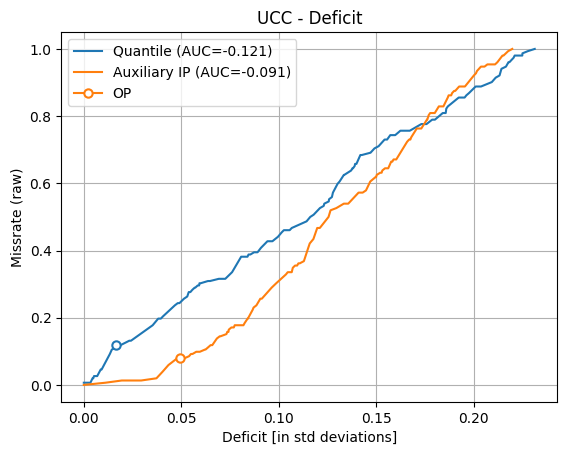

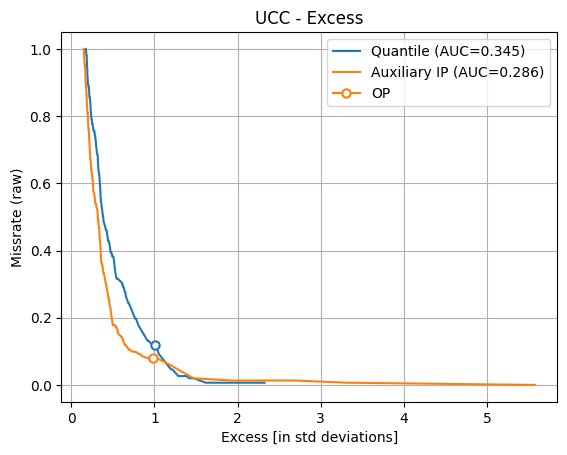

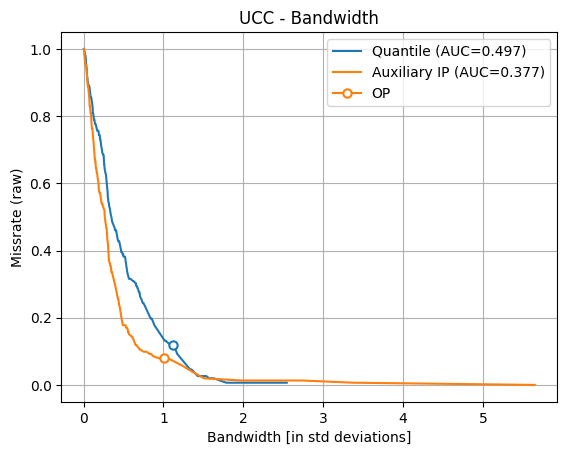

In [21]:
# Plotting UCC, comparing models
%matplotlib inline
def form_data(yhat, zhatl, zhatu): # handy routine to format data as needed by the UCC fit() method
    D = np.zeros([yhat.shape[0],3])
    D[:, 0] = yhat
    D[:, 1] = zhatl
    D[:, 2] = zhatu
    return D

# for QR
pred_qr = pred_df_qr_sorted['y_mean'] # target predictions
actual = pred_df_qr_sorted['y_test'] # ground truth observations
lb = pred_df_qr_sorted['y_lower'] # lower bound of the prediction interval 
ub = pred_df_qr_sorted['y_upper'] # upper bound of the prediction interval 
bwl_qr = pred_qr - lb # lower band (deviate) 
bwu_qr = ub - pred_qr # upper band (deviate)

# for AIP
pred_aip = pred_df_aip_sorted['y_mean'] # target predictions
actual = pred_df_aip_sorted['y_test'] # ground truth observations
lb = pred_df_aip_sorted['y_lower'] # lower bound of the prediction interval 
ub = pred_df_aip_sorted['y_upper'] # upper bound of the prediction interval 
bwl_aip = pred_aip - lb # lower band (deviate) 
bwu_aip = ub - pred_aip # upper band (deviate)

# form matrix for ucc X input
matrix_qr = form_data(pred_qr, bwl_qr, bwu_qr)
matrix_aip = form_data(pred_aip, bwl_aip, bwu_aip)

# create an instance of ucc and fit data
u = ucc()
u.fit([matrix_qr,matrix_aip], actual) #X and Y, X are the predictions given in proper format

# set appropriate coordinates and plot the UCC, show the AUUCC, and the OP:
u.set_coordinates(x_axis_name='deficit', y_axis_name='missrate', normalize=True) # axis==’missrate’ will never get normalized, even with normalize == True
auucc, op_info = u.plot_UCC(titlestr=('UCC - Deficit'), syslabel=['Quantile', 'Auxiliary IP']) #op is tuple (xaxis value, yaxis value, xunit, yunit)

u.set_coordinates(x_axis_name='excess', y_axis_name='missrate', normalize=True)
auucc, op_info = u.plot_UCC(titlestr=('UCC - Excess'), syslabel=['Quantile', 'Auxiliary IP'])

u.set_coordinates(x_axis_name='bandwidth', y_axis_name='missrate', normalize=True)
auucc, op_info = u.plot_UCC(titlestr=('UCC - Bandwidth'), syslabel=['Quantile', 'Auxiliary IP'])

# Communicating UQ

In [22]:
# Fitting a normal distribution to data, 'mean' is NumPy ndarray
mu_qr, std_qr = stats.norm.fit(y_mean_qr)
mu_aip, std_aip = stats.norm.fit(y_mean_aip)
# Create a normal distribution object with the estimated parameters
distribution_qr = stats.norm(mu_qr, std_qr) 
distribution_aip = stats.norm(mu_aip, std_aip) 

In [23]:
distribution_qr

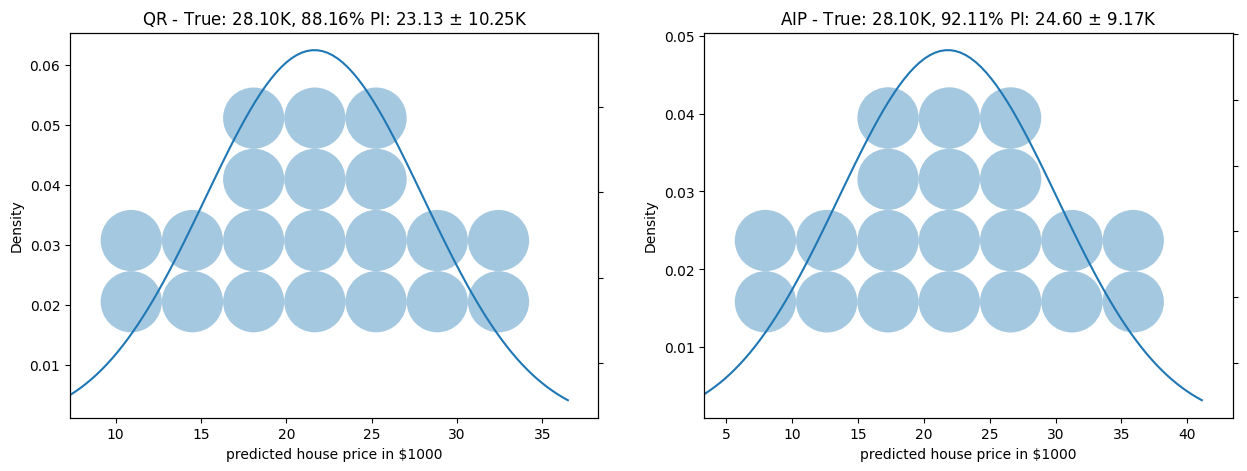

In [24]:
fig, axs = plt.subplots(1, 2,figsize=(15,5))
plot_uncertainty_distribution(distribution_qr, show_quantile_dots=True, qd_sample=20, qd_bins=7, ax=axs[0],xlabel = "predicted house price in $1000",title=r"QR - True: {:.2f}K, {:.2f}% PI: {:.2f} $\pm$ {:.2f}K".format(
                                 y_test[100][0],
                                picp(y_test, y_lower_qr, y_upper_qr)*100, y_mean_qr[100][0], mpiw(y_lower_qr, y_upper_qr)/2))
plot_uncertainty_distribution(distribution_aip, show_quantile_dots=True, qd_sample=20, qd_bins=7, ax=axs[1],xlabel = "predicted house price in $1000",title=r"AIP - True: {:.2f}K, {:.2f}% PI: {:.2f} $\pm$ {:.2f}K".format(
                                 y_test[100][0],
                                picp(y_test, y_lower_aip, y_upper_aip)*100, y_mean_aip[100][0], mpiw(y_lower_aip, y_upper_aip)/2))
plt.show()